In [20]:
# Load in relevant modules
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Define functions

def optimize_dosing(n_admin, V_max_u_mut, k_m_u_mut, V_max_u_wt, k_m_u_wt, dose_wt, BV, BSA_u, t_max, t_step, plot=True):
    # Initialize the model
    m = GEKKO(remote=True)

    # Define the number of time steps and time vector
    m.time = np.arange(1, t_max+1, t_step).tolist()
    num_steps = len(m.time)
    t = m.Var(0)
    m.Equation(t.dt()==1)

    # Setting up target curve
    C_B_target = m.Var(value=dose_wt/BV, name="C_B_target")  # Blood concentration in mg/L
    M_target = m.Var(value=0.0, name = "M_target")  # Total amount of drug metabolized (mg)

    m.Equation(C_B_target == (dose_wt - M_target) / BV)  # Rate of change of blood concentration
    m.Equation(M_target.dt() == (V_max_wt * C_B_target) / (k_m_wt + C_B_target))  # Michaelis-Menten kinetics

    # Setting up patient curve (not optimized)
    C_B_pat = m.Var(value=dose_wt/BV, name="C_B_pat")  # Blood concentration in mg/L
    M_pat = m.Var(value=0.0, name = "M_pat")  # Total amount of drug metabolized (mg)

    m.Equation(C_B_pat == (dose_wt - M_pat) / BV)  # Rate of change of blood concentration
    m.Equation(M_pat.dt() == (V_max_mut * C_B_pat) / (k_m_mut + C_B_pat))  # Michaelis-Menten kinetics

    # Setting up personalized curve
    #"step function" for adminstration of all but first doses, using tanh as switch function b/c gekko doesn't like discontinuity and tanh is close enough
    dose_init = m.FV(3.48,0,6, name = "dose_init") # Initial Dose Parameter, with minimum of zero
    dose_init.STATUS = 1

    if n_admin >= 2:
        dose_two = m.FV(1.6,0,6, name = "dose_two") # Second Dose Parameter, with minimum of zero
        dose_two.STATUS = 1

        time_two = m.FV(40,0,(t_max*9)//10, name = "time_two") # Timing of second Dose Parameter, minimum of zero, max of 90% of sim time
        time_two.STATUS = 1

        h_2 = m.Var(0,name="h_2")
        m.Equation(h_2 == (m.tanh(4*(t-time_two))/2+0.5)*dose_two)

    if n_admin >= 3:
        dose_three = m.FV(1,0,6, name = "dose_three") # third Dose Parameter, with minimum of zero
        dose_three.STATUS = 1

        time_three = m.FV(100,0,(t_max*9)//10, name = "time_three") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
        time_three.STATUS = 1

        h_3 = m.Var(0,name="h_3")
        m.Equation(h_3 == (m.tanh(4*(t-time_three))/2+0.5)*dose_three)

    if n_admin >= 4:
        dose_four = m.FV(0.3,0,6, name = "dose_four") # third Dose Parameter, with minimum of zero
        dose_four.STATUS = 1

        time_four = m.FV(150,0,(t_max*9)//10, name = "time_four") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
        time_four.STATUS = 1

        h_4 = m.Var(0,name="h_4")
        m.Equation(h_4 == (m.tanh(4*(t-time_four))/2+0.5)*dose_four)

    if n_admin >= 5:
        dose_five = m.FV(0.1,0,6, name = "dose_five") # third Dose Parameter, with minimum of zero
        dose_five.STATUS = 1

        time_five = m.FV(200,0,(t_max*9)//10, name = "time_five") # Timing of third Dose Parameter, minimum of zero, max of 90% of sim time
        time_five.STATUS = 1

        h_5 = m.Var(0,name="h_5")
        m.Equation(h_5 == (m.tanh(4*(t-time_five))/2+0.5)*dose_five)

    h_tot = m.Var(dose_init, name="h_tot")
    d_tot = m.Var(dose_init, name="d_tot")

    if n_admin == 1:
        m.Equation(h_tot == dose_init)
        m.Equation(d_tot == dose_init)
    elif n_admin == 2:
        m.Equation(h_tot == dose_init + h_2)
        m.Equation(d_tot == dose_init + dose_two)
    elif n_admin == 3:
        m.Equation(h_tot == dose_init + h_2 + h_3)
        m.Equation(d_tot == dose_init + dose_two + dose_three)
    elif n_admin == 4:
        m.Equation(h_tot == dose_init + h_2 + h_3 + h_4)
        m.Equation(d_tot == dose_init + dose_two + dose_three + dose_four)
    elif n_admin == 5:
        m.Equation(h_tot == dose_init + h_2 + h_3 + h_4 + h_5)
        m.Equation(d_tot == dose_init + dose_two + dose_three + dose_four + dose_five)

    C_B_mut = m.Var(value=dose_init/BSA_u, name="C_B_mut")  # Blood concentration in mg/L
    M_mut = m.Var(value=0.0, name = "M_mut")  # Total amount of drug metabolized (mg)

    m.Equation(C_B_mut == (h_tot - M_mut) / BV)  # Rate of change of blood concentration
    m.Equation(M_mut.dt() == (V_max_mut * C_B_mut) / (k_m_mut + C_B_mut))  # Michaelis-Menten kinetics

    # Optimization target

    conc_cost_inst = m.Var(0, name="j_conc_cost_inst")
    m.Equation(conc_cost_inst == (C_B_target - C_B_mut)**2)
    conc_cost = m.Var(0, name = "j_conc_cost")
    m.Equation(conc_cost.dt() == conc_cost_inst)

    w1 = 1
    #w2 = 1/100
    w2 = 1/200
    cost_tot = m.Var(name = "j_cost_tot")
    m.Equation(cost_tot == w1*conc_cost + w2*(d_tot)**2)
    #m.Minimize(cost_tot)

    cost_tot_amortized = m.Var(name = "j_cost_tot_amortized")
    m.Equation(cost_tot_amortized == 1*(w1*conc_cost_inst*t_step + w2/num_steps*((d_tot)**2)))
    m.Obj(cost_tot_amortized)

    # Solve the optimization problem
    m.options.IMODE = 6 # optimal control mode
    m.options.MAX_ITER = 100
    m.options.DIAGLEVEL = 1
    m.options.MAX_TIME = 300
    m.options.REDUCE = 5
    #m.open_folder()
    m.options.SOLVER = 1  # APOPT solver
    m.solve(disp=False, debug = 0) # solve
    

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(m.time, C_B_target, label='Target via SOC', linestyle='--', color='skyblue')
        plt.plot(m.time, C_B_mut, label='Optimized via OCT', linestyle='-', color='salmon')
        plt.plot(m.time, C_B_pat, label='Simulated via SOC', linestyle='-', color='purple')

        plt.xlabel('Time (min)')
        plt.ylabel('Blood Level Concentration (mg/L)')
        plt.title('Comparison of Target vs Optimized Blood Level Concentration')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Save out the appropriate values 
    C_B_target_vals = C_B_target.value
    C_B_mut_vals = C_B_mut.value
    time_vals = m.time
    cost = m.options.OBJFCNVAL

    init_dose_val = dose_init.value[1]
    dose_params = [dose_init.value[1]]
    time_params = [0] # add initial time manually since gekko does not store it 

    for i in range(2, n_admin + 1):
        dose_name = f"dose_{['init','two','three','four','five'][i-1]}"
        time_name = f"time_{['init','two','three','four','five'][i-1]}"

        dose_obj = locals().get(dose_name)
        time_obj = locals().get(time_name)

        if dose_obj is not None:
            dose_params.append(dose_obj.value[1])
        if time_obj is not None:
            time_params.append(time_obj.value[1])

    return {
        'cost': cost,
        'initial_dose': init_dose_val,
        'doses': dose_params,
        'times': time_params,
        'params': {
            'V_max_u_mut': V_max_u_mut,
            'k_m_u_mut': k_m_u_mut,
            'V_max_u_wt': V_max_u_wt,
            'k_m_u_wt': k_m_u_wt,
            'dose_wt': dose_wt,
            't_step': t_step
        },
        'C_B_target': C_B_target_vals,
        'C_B_mut': C_B_mut_vals,
        'C_B_pat': C_B_pat,
        'time': time_vals
    }

def convert_units(V_max, k_m, pmol_cyp, mm_drug):
    V_max_updated = V_max * pmol_cyp * mm_drug * (10 ** -9)
    k_m_updated = k_m * (10 ** -2) * mm_drug

    return V_max_updated, k_m_updated


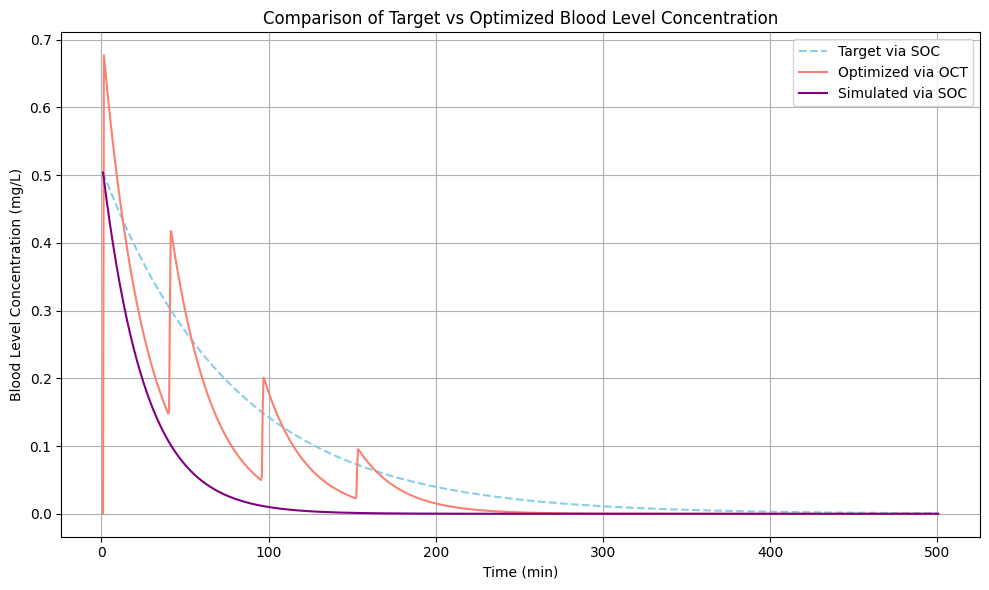

In [22]:
# Define variables 

n_admin = 4 # CHANGE THIS; must be 1-5 for this framework

V_max_u_wt = 3.5              # pmol/min per pmol cyp
k_m_u_wt = 16                 # umol/L

#example fast metabolizer case
V_max_u_mut = 8.2              # pmol/min per pmol cyp
k_m_u_mut = 12                 # umol/L

#example slow metabolizer case
#V_max_u_mut = 2              # pmol/min per pmol cyp
#k_m_u_mut = 32                # umol/L

#example average metabolizer case (same as wild type)
#V_max_u_mut = 3.5              # pmol/min per pmol cyp
#k_m_u_mut = 16                 # umol/L

# Set 
dose_u = 1.4               # [mg/m^2]
BV_u = 5                   # L
BV = BV_u
BSA_u = 1.8                # m^2
dose_wt = dose_u * BSA_u   # mg
pmol_cyp = 2929510         # pmol cyp
mm_cyp = 57343             # g/mol for cyp
mm_drug = 825              # g/mol for vincristine

t_max = 500                # min
t_step = 0.5               # min


# Call the functions 

# Convert units 
V_max_wt, k_m_wt = convert_units(V_max_u_wt, k_m_u_wt, pmol_cyp, mm_drug)
V_max_mut, k_m_mut = convert_units(V_max_u_mut, k_m_u_mut, pmol_cyp, mm_drug)

# Conduct forward run and OCT optimization 
results = optimize_dosing(n_admin, V_max_mut, k_m_mut, V_max_wt, k_m_wt, dose_wt, BV, BSA_u, t_max, t_step, plot=True)

In [23]:
# Let's see the results
print("Total cost:", results['cost'])
print("Initial dose:", results['initial_dose'])
print("All dose amounts:", results['doses'])
print("All dose times:", results['times'])

# For plotting or analysis ... 
C_B_target = results['C_B_target']
C_B_mut = results['C_B_mut']
C_B_pat = results['C_B_pat']
time = results['time']

Total cost: 1.0992393963
Initial dose: 3.452720438
All dose amounts: [3.452720438, 1.4548655263, 0.80384816687, 0.38563273717]
All dose times: [0, 39.967312137, 95.398210997, 151.92319494]


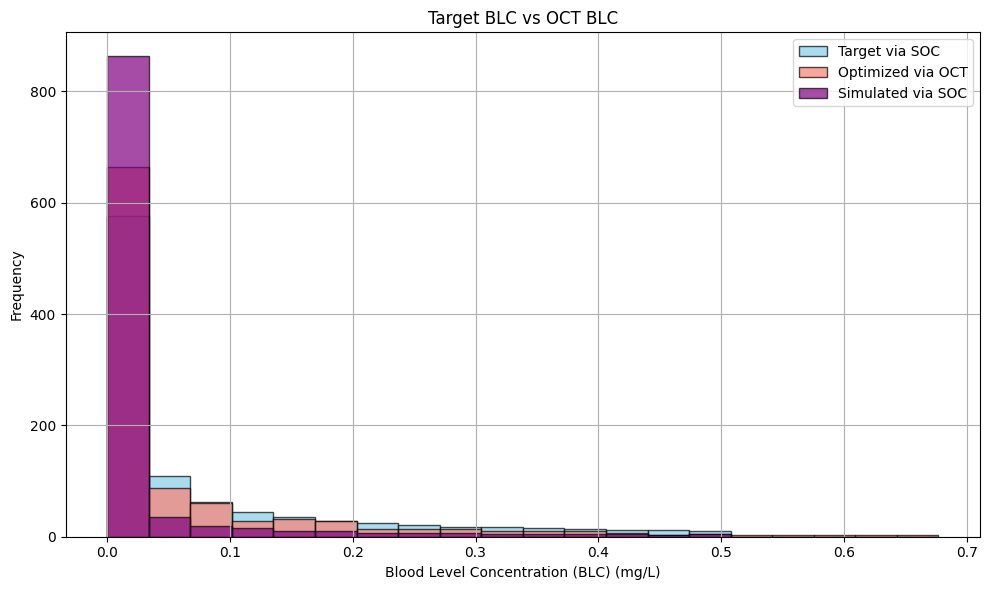

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Combine both arrays to get shared bin edges
all_values = np.concatenate([C_B_target, C_B_mut, C_B_pat])
bins = np.histogram_bin_edges(all_values, bins=20)  # or use a fixed range if preferred

plt.figure(figsize=(10, 6))

# Improved color palette
plt.hist(C_B_target, bins=bins, alpha=0.7, label='Target via SOC', color='skyblue', edgecolor='black')
plt.hist(C_B_mut, bins=bins, alpha=0.7, label='Optimized via OCT', color='salmon', edgecolor='black')
plt.hist(C_B_pat, bins=bins, alpha=0.7, label='Simulated via SOC', color='purple', edgecolor='black')

plt.xlabel('Blood Level Concentration (BLC) (mg/L)')
plt.ylabel('Frequency')
plt.title('Target BLC vs OCT BLC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import wilcoxon

# Convert GEKKO variables to numpy arrays
C_B_target_values = np.array([float(val) for val in C_B_target])
C_B_mut_values = np.array([float(val) for val in C_B_mut])
C_B_pat_values = np.array([float(val) for val in C_B_pat])

# Wilcoxon signed-rank test for SOC (Target vs Simulated)
stat, p_val = wilcoxon(C_B_target_values, C_B_pat_values)
print(f"Wilcoxon Signed-Rank Statistic (SOC): {stat:.4f}")
print(f"P-value (SOC): {p_val:.4e}")

alpha = 0.05
if p_val < alpha:
    print("Result: Distributions are significantly different (reject H0).")
else:
    print("Result: No significant difference between distributions (fail to reject H0).")

print("-" * 50)

# Wilcoxon signed-rank test for OCT (Target vs Optimized)
stat2, p_val2 = wilcoxon(C_B_target_values, C_B_mut_values)
print(f"Wilcoxon Signed-Rank Statistic (OCT): {stat2:.4f}")
print(f"P-value (OCT): {p_val2:.4e}")

if p_val2 < alpha:
    print("Result: Distributions are significantly different (reject H0).")
else:
    print("Result: No significant difference between distributions (fail to reject H0).")


Wilcoxon Signed-Rank Statistic (SOC): 0.0000
P-value (SOC): 4.8415e-165
Result: Distributions are significantly different (reject H0).
--------------------------------------------------
Wilcoxon Signed-Rank Statistic (OCT): 62842.0000
P-value (OCT): 1.6101e-93
Result: Distributions are significantly different (reject H0).


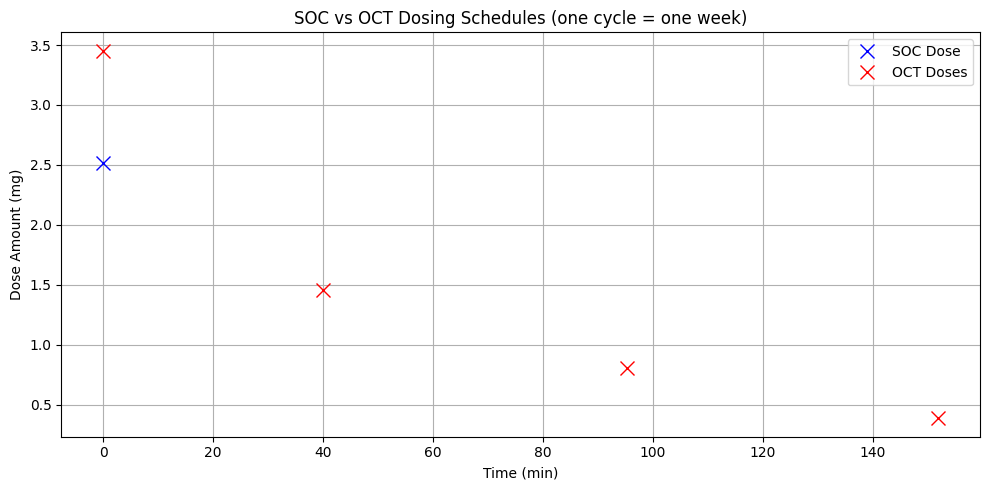

In [26]:
import matplotlib.pyplot as plt

# SOC dose: one dose at time 0
soc_dose_amount = 1.4*BSA_u
soc_times = [0]
soc_doses = [soc_dose_amount] * len(soc_times)

# OCT optimized dosing
oct_dose_amounts = results['doses']
oct_times = results['times']

plt.figure(figsize=(10, 5))

# Plot SOC dose with 'x' markers and thicker lines
plt.plot(soc_times, soc_doses, 'bx', markersize=10, linewidth=3, label='SOC Dose')

# Plot OCT doses with 'x' markers and thicker lines
plt.plot(oct_times, oct_dose_amounts, 'rx', markersize=10, linewidth=3, label='OCT Doses')

plt.xlabel('Time (min)')
plt.ylabel('Dose Amount (mg)')
plt.title('SOC vs OCT Dosing Schedules (one cycle = one week)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print("OCT times:", oct_times)
print("OCT dose amounts:", oct_dose_amounts)
print("Length of times:", len(oct_times))
print("Length of doses:", len(oct_dose_amounts))

OCT times: [0, 39.967312137, 95.398210997, 151.92319494]
OCT dose amounts: [3.452720438, 1.4548655263, 0.80384816687, 0.38563273717]
Length of times: 4
Length of doses: 4
